In [1]:
from tensorflow.keras.models import load_model

model = load_model('modeloFinal.h5', compile = False)

In [2]:
model

In [12]:
import keras
print(keras.__version__)

2.4.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

print(tf.__version__)

2.4.0


In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convierte un conjunto de series de tiempo en un conjunto de aprendizaje supervisado

    Params:
        data: secuencia de observaciones
        n_in: tamaño de la ventana, es decir, 2 implica que el siguiente valor
            se calculara con los dos anteriores
        n_out: número de variables a predecir
        dropnan: indica si se eliminarán los valores nulos
    Returns:
    Conjunto de datos de un problema de aprendizaje supervisado
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # shift
        # se utiliza para desplazar el índice de DataFrame por un número 
        # determinado de períodos con una frecuencia de tiempo opcional
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def get_data(df, ventana):
    '''
    Transforma nuestros datos en un formato aceptable para la red separandolos en train y test

    Params:
      df: conjunto de datos 
      ventana: número de días con el que se predecirá el siguiente
    '''
    n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
    entrenamiento = 800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
    n_obs = ventana*n_cols
    
    
    values = df.iloc[1082:,1:].values# Desde el primer dia del 2018
    transformer = StandardScaler()
    transformer.fit(values)
    # se escalan los datos para que la red trabaje mejor
    transformer_y = StandardScaler()
    transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

    values = transformer.transform(values)
    # obtenemos un datos para un problema supervisado
    data = series_to_supervised(values, ventana,1 )
    
    train = data.iloc[:entrenamiento,:]
    test = data.iloc[entrenamiento:,:]

    train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
    test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values
    
    # modificamos las dimensiones del train y test para que tengan un formato
    # (muestras, ventana, numero de variables)
    train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
    test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))
    return train_X, train_y, test_X, test_y

In [6]:
df = pd.read_csv("data_complete.csv")
df.columns

Index(['date', 'dow(USD)', 'euro_stoxx50(USD)', 'nasdaq(USD)', 'nikkei(USD)',
       'oro(USD)', 'petroleo(USD)', 'shangai_stock_exchange(USD)',
       'sp_500(USD)', 'BCHAIN-TOTBC', 'BCHAIN-AVBLS', 'BCHAIN-MIREV (USD)',
       'BCHAIN-HRATE', 'BCHAIN-NTRBL', 'BCHAIN-NADDU', 'eur_usd', 'cny_usd',
       'gbp_usd', 'BCHAIN-MKPRU (USD)'],
      dtype='object')

In [7]:
df.drop(['shangai_stock_exchange(USD)','petroleo(USD)','euro_stoxx50(USD)','dow(USD)'], axis=1, inplace = True)

In [8]:
train_X, train_y, test_X, test_y = get_data(df, 3)

In [9]:
values = df.iloc[1082:,1:].values
transformer_y = StandardScaler()
transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

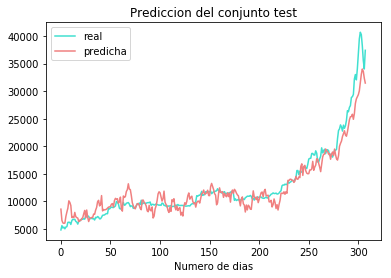

In [10]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

Text(0.5,0,'Numero de dias')

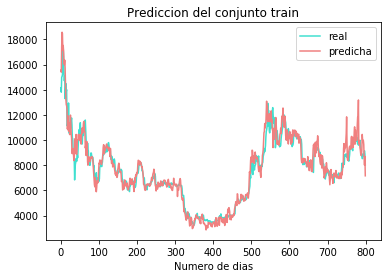

In [11]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")